# Objectives
Start by examining the data dictionary for the SQL database we'll be working with, which comes from this kaggle page. Familiarize yourself with the tables it contains, and what each column means. We'll be using this database to get data on each soccer team, calculate some summary statistics, and then store each in a MongoDB database.

Upon completion of this lab, each unique team in this dataset should have a record in the MongoDB instance containing the following information:

The name of the team
The total number of goals scored by the team during the 2011 season
The total number of wins the team earned during the 2011 season
A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)
The team's win percentage on days where it was raining during games in the 2011 season.

# Import Libraries

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdb

import sqlite3 
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

import requests
from pprint import pprint
import json

from datetime import date, datetime
import time
import pymongo
import os

import dotenv
from dotenv import load_dotenv

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
sns.set_context('poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
!pip install python-dotenv

 # Inspecting Data (Query the SQL database)

In [3]:
cur.execute('''SELECT * FROM matches;''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head(10)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A
5,6,D2,2009,2010-04-03,Union Berlin,Karlsruhe,1,1,D
6,7,D2,2009,2009-08-14,Paderborn,Karlsruhe,2,0,H
7,8,D2,2009,2010-03-08,Bielefeld,Karlsruhe,0,1,A
8,9,D2,2009,2009-09-26,Kaiserslautern,Karlsruhe,2,0,H
9,10,D2,2009,2009-11-21,Hansa Rostock,Karlsruhe,2,1,H


In [4]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
cur.fetchall()

[('sqlite_sequence',),
 ('Matches',),
 ('Teams_in_Matches',),
 ('Teams',),
 ('Unique_Teams',)]

 # Inspecting the tables in the database

In [5]:
#sqlite_sequence table
cur.execute('''
SELECT *
FROM sqlite_sequence
''')
seq_df = pd.DataFrame(cur.fetchall())
seq_df.columns = [x[0] for x in cur.description]
seq_df.head()

,name,seq
0,Matches,46774
1,Unique_Teams,128


# Calculate summary statistics

# Teams and Games Tables 

Unique Teams' Table

In [6]:
cur.execute('''
SELECT *
FROM Unique_Teams
''')
unique_teams_df= pd.DataFrame(cur.fetchall())
unique_teams_df.columns = [x[0] for x in cur.description]
unique_teams_df.head(15)

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3
3,RB Leipzig,4
4,Schalke 04,5
5,M'gladbach,6
6,Wolfsburg,7
7,FC Koln,8
8,Hoffenheim,9
9,Hertha,10


In [7]:
#Teams table
cur.execute('''
SELECT *
FROM Teams
''')
teams_df = pd.DataFrame(cur.fetchall())
teams_df.columns = [x[0] for x in cur.description]
teams_df.head()

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


In [8]:
#Teams table
cur.execute('''
SELECT *
FROM Matches
''')
teams_df= pd.DataFrame(cur.fetchall())
teams_df.columns = [x[0] for x in cur.description]
teams_df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [9]:
# Accessing the unique team names on the table 
cur.execute('''SELECT * FROM unique_teams;''')
unique_teams_df = pd.DataFrame(cur.fetchall())
unique_teams_df.columns = [x[0] for x in cur.description]
unique_teams_df.head()

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3
3,RB Leipzig,4
4,Schalke 04,5


In [10]:
name_all_teams_df = list(unique_teams_df.TeamName)
print(name_all_teams_df)

['Bayern Munich', 'Dortmund', 'Leverkusen', 'RB Leipzig', 'Schalke 04', "M'gladbach", 'Wolfsburg', 'FC Koln', 'Hoffenheim', 'Hertha', 'Mainz', 'Hamburg', 'Werder Bremen', 'Ein Frankfurt', 'Augsburg', 'Freiburg', 'Stuttgart', 'Hannover', 'Ingolstadt', 'Darmstadt', 'Paderborn', 'Nurnberg', 'Braunschweig', 'Greuther Furth', 'Fortuna Dusseldorf', 'Kaiserslautern', 'St Pauli', 'Bochum', 'Karlsruhe', 'Bielefeld', 'Cottbus', 'Duisburg', 'Hansa Rostock', 'Aachen', 'Union Berlin', 'Heidenheim', 'Dresden', 'Sandhausen', 'Erzgebirge Aue', 'Kiel', 'Regensburg', 'Munich 1860', 'Wurzburger Kickers', 'Frankfurt FSV', 'Aalen', 'Oberhausen', 'Osnabruck', 'Koblenz', 'Ahlen', 'Wehen', 'CZ Jena', 'Offenbach', 'Essen', 'Burghausen', 'Unterhaching', 'Saarbrucken', 'Siegen', 'Babelsberg', 'Chemnitz', 'Ein Trier', 'Erfurt', 'F Koln', 'Gutersloh', 'Homburg', 'Leipzig', 'Lubeck', 'Mannheim', 'Meppen', 'Oldenburg', 'Reutlingen', 'Schweinfurt', 'Stuttgarter K', 'TB Berlin', 'Uerdingen', 'Ulm', 'Wattenscheid', 'Wu

# Inspecting the amount of Goals scored during the specified season (2011)

In [125]:
cur.execute("""SELECT AwayTeam AS Team, SUM(FTAG) AS AwayGoals
               FROM matches
               WHERE Season = '2011'
               AND NOT Div ='E0'
               GROUP BY AwayTeam;""")
AwayGoals_df = pd.DataFrame(cur.fetchall())
AwayGoals_df.columns = [x[0] for x in cur.description]
AwayGoals_df.head(56)

,Team,AwayGoals
0,Aachen,15
1,Augsburg,16
2,Bayern Munich,28
3,Bochum,18
4,Braunschweig,16
5,Cottbus,12
6,Dortmund,36
7,Dresden,20
8,Duisburg,19
9,Ein Frankfurt,38


In [12]:
cur.execute('''SELECT Season, HomeTeam AS Team, SUM(FTHG) AS HomeGoals
               FROM Matches
               Where Season = 2011
               AND NOT Div ='E0'
               GROUP BY HomeTeam
               ;''')
HomeGoals_df = pd.DataFrame(cur.fetchall())
HomeGoals_df.columns = [x[0] for x in cur.description]
HomeGoals_df.head()

,Season,Team,HomeGoals
0,2011,Aachen,15
1,2011,Augsburg,20
2,2011,Bayern Munich,49
3,2011,Bochum,23
4,2011,Braunschweig,21


In [13]:
team_goals_df = (pd.merge(HomeGoals_df, AwayGoals_df, on='Team'))
team_goals_df.head()

,Season,Team,HomeGoals,AwayGoals
0,2011,Aachen,15,15
1,2011,Augsburg,20,16
2,2011,Bayern Munich,49,28
3,2011,Bochum,23,18
4,2011,Braunschweig,21,16


In [122]:
team_goals_df['TotalGoals']= HomeGoals_df.HomeGoals + AwayGoals_df.AwayGoals
team_goals_df.head(56)

,HomeTeam,Home_Goals,TotalGoals
0,Aachen,15,30.0
1,Arsenal,39,36.0
2,Aston Villa,20,77.0
3,Augsburg,20,41.0
4,Bayern Munich,49,37.0
5,Blackburn,26,30.0
6,Bochum,23,80.0
7,Bolton,23,50.0
8,Braunschweig,21,42.0
9,Chelsea,41,76.0


# Total amount of Wins in the season

In [15]:
cur.execute('''
SELECT *
FROM Matches;
''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [16]:
cur.execute('''SELECT AwayTeam, SUM(FTAG) AS Away_Goals
            FROM Matches
            WHERE Season = 2011
            GROUP BY 1;'''
           )

away_goals_df = pd.DataFrame(cur.fetchall())
away_goals_df.columns = [x[0] for x in cur.description]
away_goals_df.head(10)

,AwayTeam,Away_Goals
0,Aachen,15
1,Arsenal,35
2,Aston Villa,17
3,Augsburg,16
4,Bayern Munich,28
5,Blackburn,22
6,Bochum,18
7,Bolton,23
8,Braunschweig,16
9,Chelsea,24


In [17]:
cur.execute('''SELECT Season, AwayTeam AS Team, COUNT(FTR) AS AwayWins
               FROM Matches
               Where Season = 2011
               AND FTR = 'A'
               AND NOT Div ='E0'
               GROUP BY HomeTeam
               ;''')
AwayWins_df = pd.DataFrame(cur.fetchall())
AwayWins_df.columns = [x[0] for x in cur.description]
AwayWins_df.head()

,Season,Team,AwayWins
0,2011,Dresden,7
1,2011,Bayern Munich,4
2,2011,Dortmund,2
3,2011,Dresden,7
4,2011,Dresden,3


In [18]:
cur.execute('''SELECT AwayTeam, SUM(FTAG) AS Away_Goals
            FROM Matches
            WHERE Season = 2011
            GROUP BY 1;'''
           
           )
goals_df = pd.DataFrame(cur.fetchall())
goals_df.columns = [x[0] for x in cur.description]
goals_df.head(18)

cur.execute('''SELECT HomeTeam, SUM(FTHG) AS Home_Goals
            FROM Matches
            WHERE Season = 2011
            GROUP BY 1;''')
team_goals_df = pd.DataFrame(cur.fetchall())
team_goals_df.columns = [x[0] for x in cur.description]
team_goals_df.head(18)

total_goals_df = team_goals_df.join(goals_df, on=None, how='left')
total_goals_df['Total_Goals_2011'] = total_goals_df['Home_Goals'] + total_goals_df['Away_Goals']
total_goals_df.head()


all_goals_df = total_goals_df.loc[:, ['AwayTeam', 'Total_Goals_2011']]
all_goals_df.rename(columns={'AwayTeam':'Team'}, inplace=True)
print(all_goals_df.info())
all_goals_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
Team                56 non-null object
Total_Goals_2011    56 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.0+ KB
None


,Team,Total_Goals_2011
0,Aachen,30
1,Arsenal,74
2,Aston Villa,37
3,Augsburg,36
4,Bayern Munich,77


# Overall Wins and Losses, and total goals scored during the 2011 season 

In [19]:
query = '''SELECT a.AwayTeam as Team,
                    SUM(a.Away_Goals + b.Home_Goals) AS Total_Goals,
                    SUM(a.Away_Wins + b.Home_Wins) AS Total_Wins,
                    SUM(a.Away_Draw + b.Home_Draw) AS Total_Draws,
                    SUM(a.Num_Games - a.Away_Wins - b.Home_Wins - a.Away_Draw - b.Home_Draw) AS Total_Losses,
                    a.Num_Games,
                    CASE WHEN a.Num_games = 38 THEN 'EPL' ELSE 'BUNDES' END AS League
                FROM (SELECT AwayTeam,
                        COUNT(AwayTeam) * 2 AS Num_Games,  
                        SUM(FTAG) AS Away_Goals,
                        COUNT(CASE WHEN FTR = 'A' THEN 1 ELSE NULL END) AS Away_Wins,
                        COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Away_Draw
                        FROM Matches
                        WHERE Season = 2011
                        GROUP BY 1) a
                LEFT JOIN
                    (SELECT HomeTeam,
                        SUM(FTHG) AS Home_Goals,
                        COUNT(CASE WHEN FTR = 'H' THEN 1 ELSE NULL END) AS Home_Wins,
                        COUNT(CASE WHEN FTR = 'D' THEN 1 ELSE NULL END) AS Home_Draw
                        FROM Matches
                        WHERE Season = 2011
                        GROUP BY 1) b
                ON a.AwayTeam = b.HomeTeam
                GROUP BY 1'''

wins_losses_goals_df = pd.read_sql_query(query, conn)
wins_losses_goals_df.head()

,Team,Total_Goals,Total_Wins,Total_Draws,Total_Losses,Num_Games,League
0,Aachen,30,6,13,15,34,BUNDES
1,Arsenal,74,21,7,10,38,EPL
2,Aston Villa,37,7,17,14,38,EPL
3,Augsburg,36,8,14,12,34,BUNDES
4,Bayern Munich,77,23,4,7,34,BUNDES


# Data Visualization for Bundesliga 2011

Text(0.5, 1.0, 'Graph Showing the total amounts of Wins, Losses, and Draws for each team in the Bundesliga 2011')

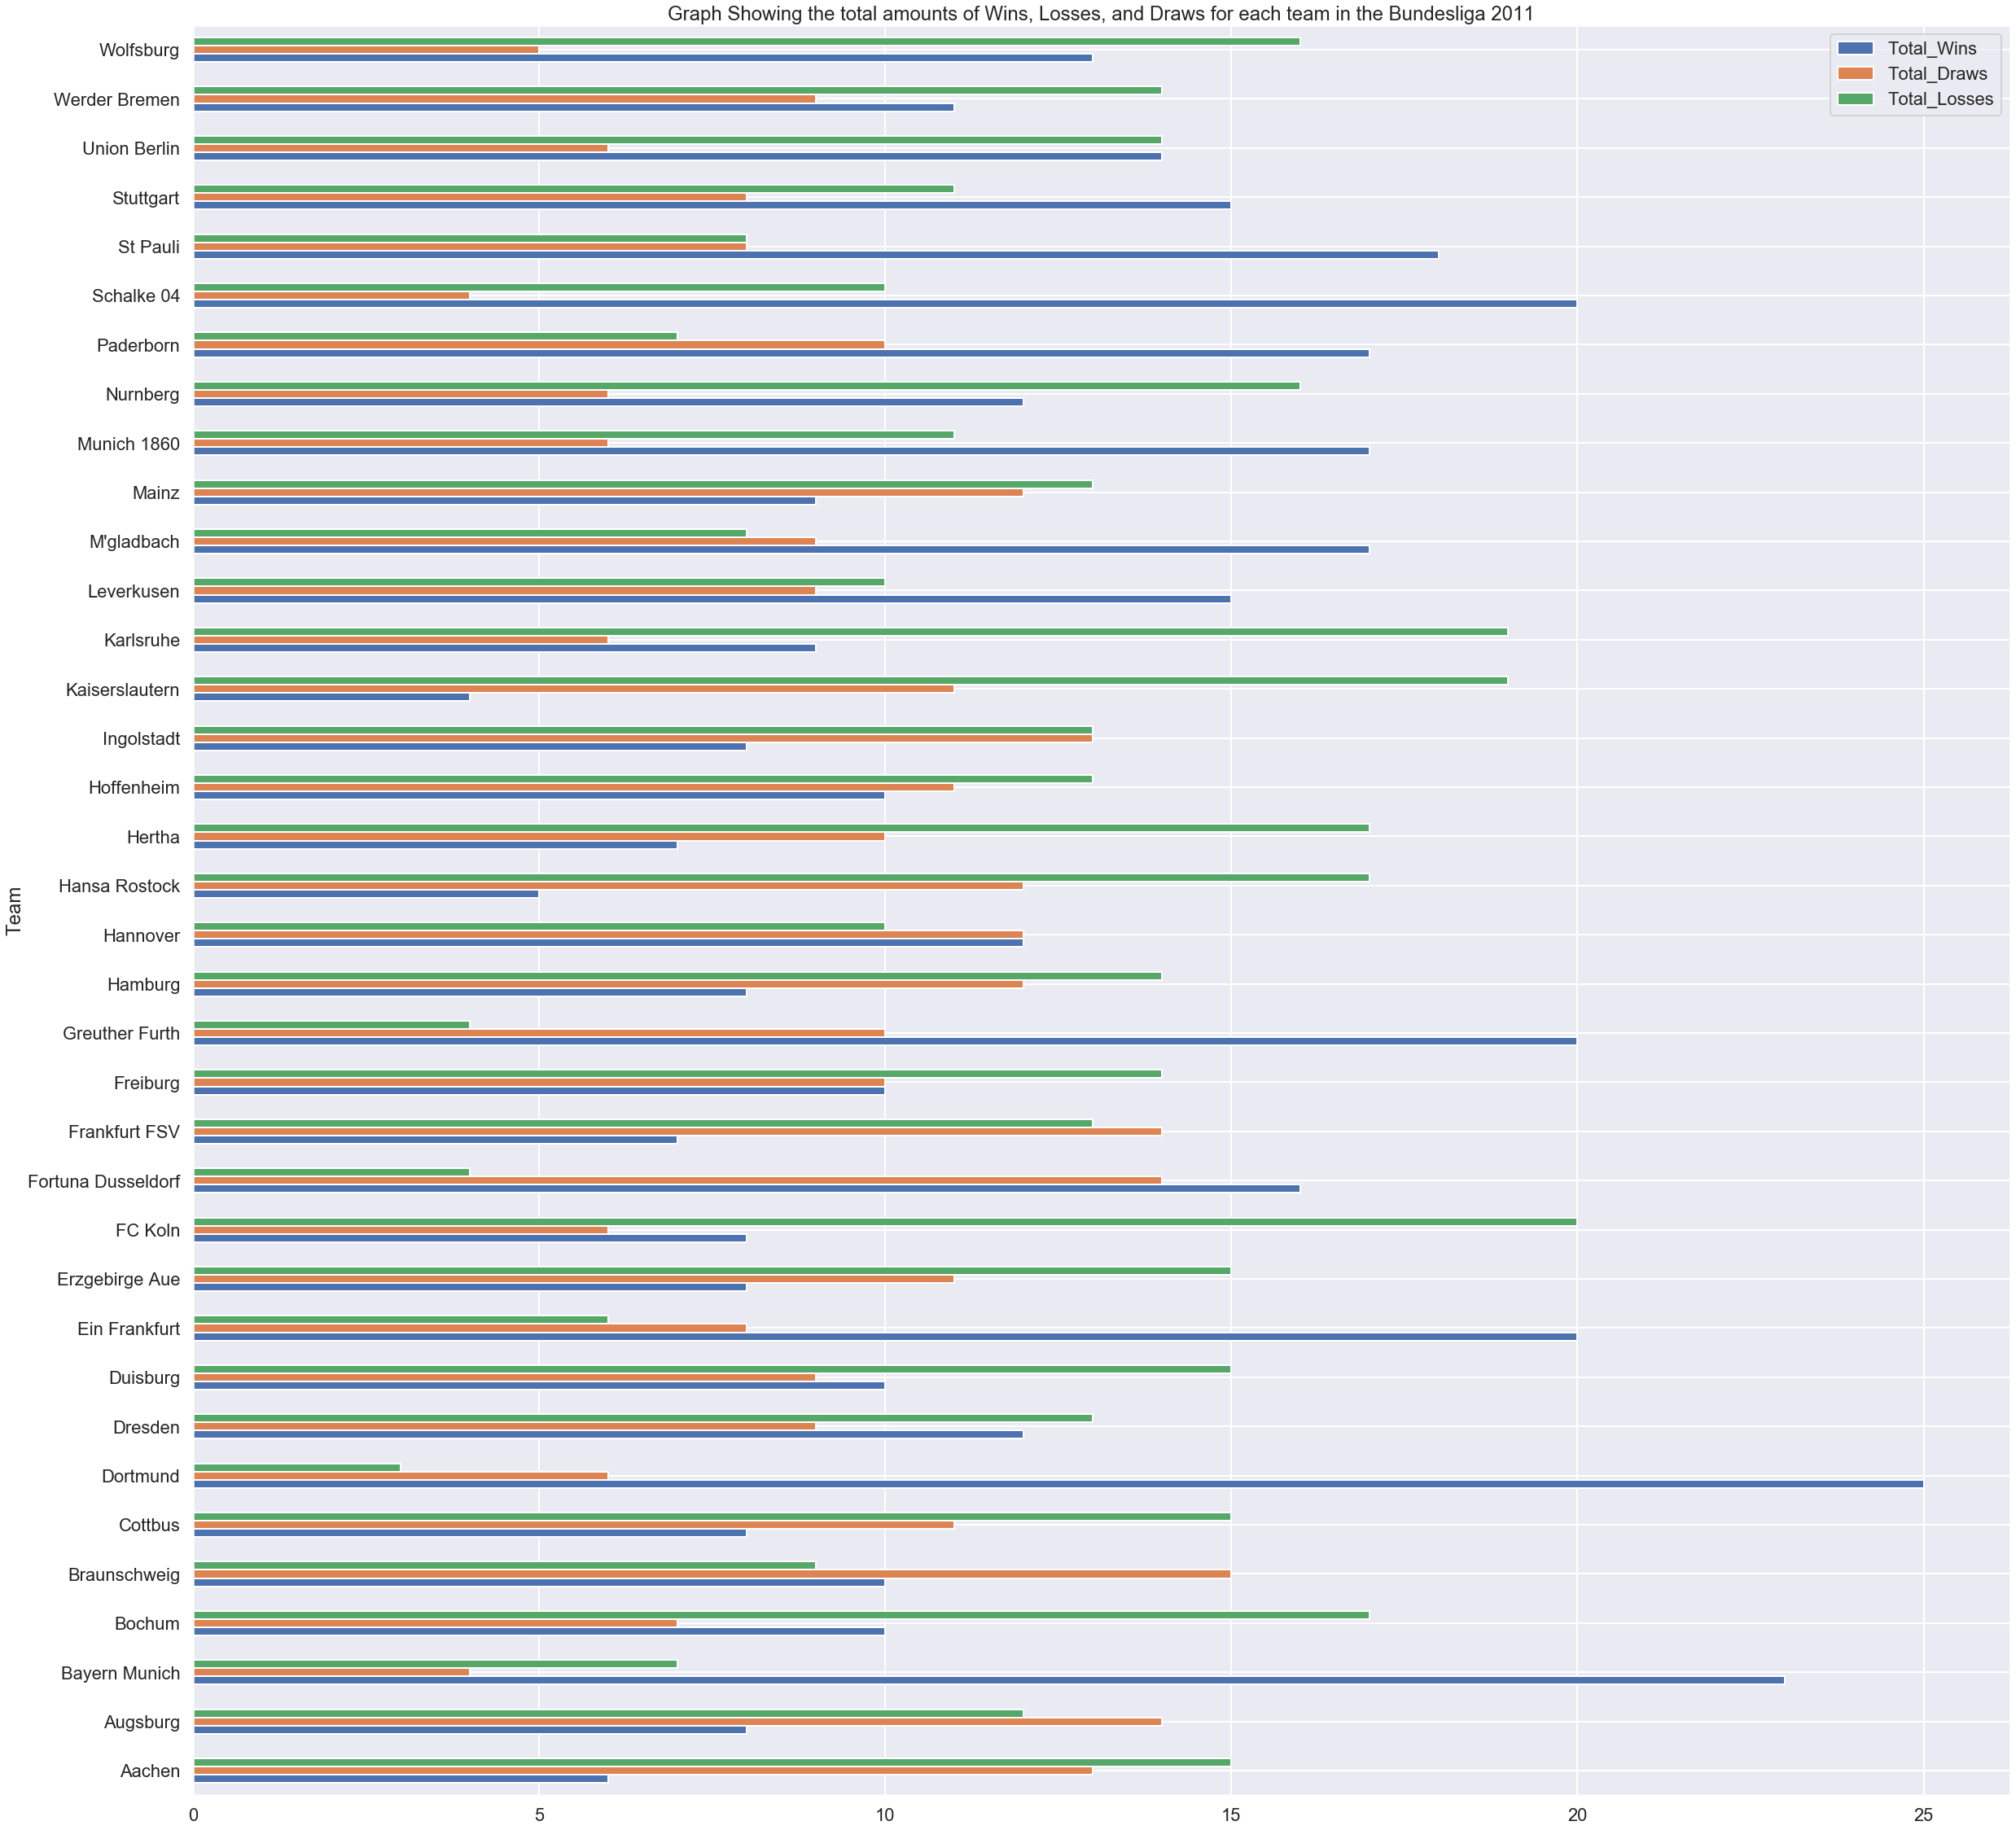

In [20]:
bundesliga_df = wins_losses_goals_df.loc[wins_losses_goals_df['League'] == 'BUNDES']
bundesliga_df.plot(kind='barh', x='Team', y=['Total_Wins', 'Total_Draws', 'Total_Losses'], figsize=(40,40))
plt.title('Graph Showing the total amounts of Wins, Losses, and Draws for each team in the Bundesliga 2011')


# Data Visualization for English Premier League 2011

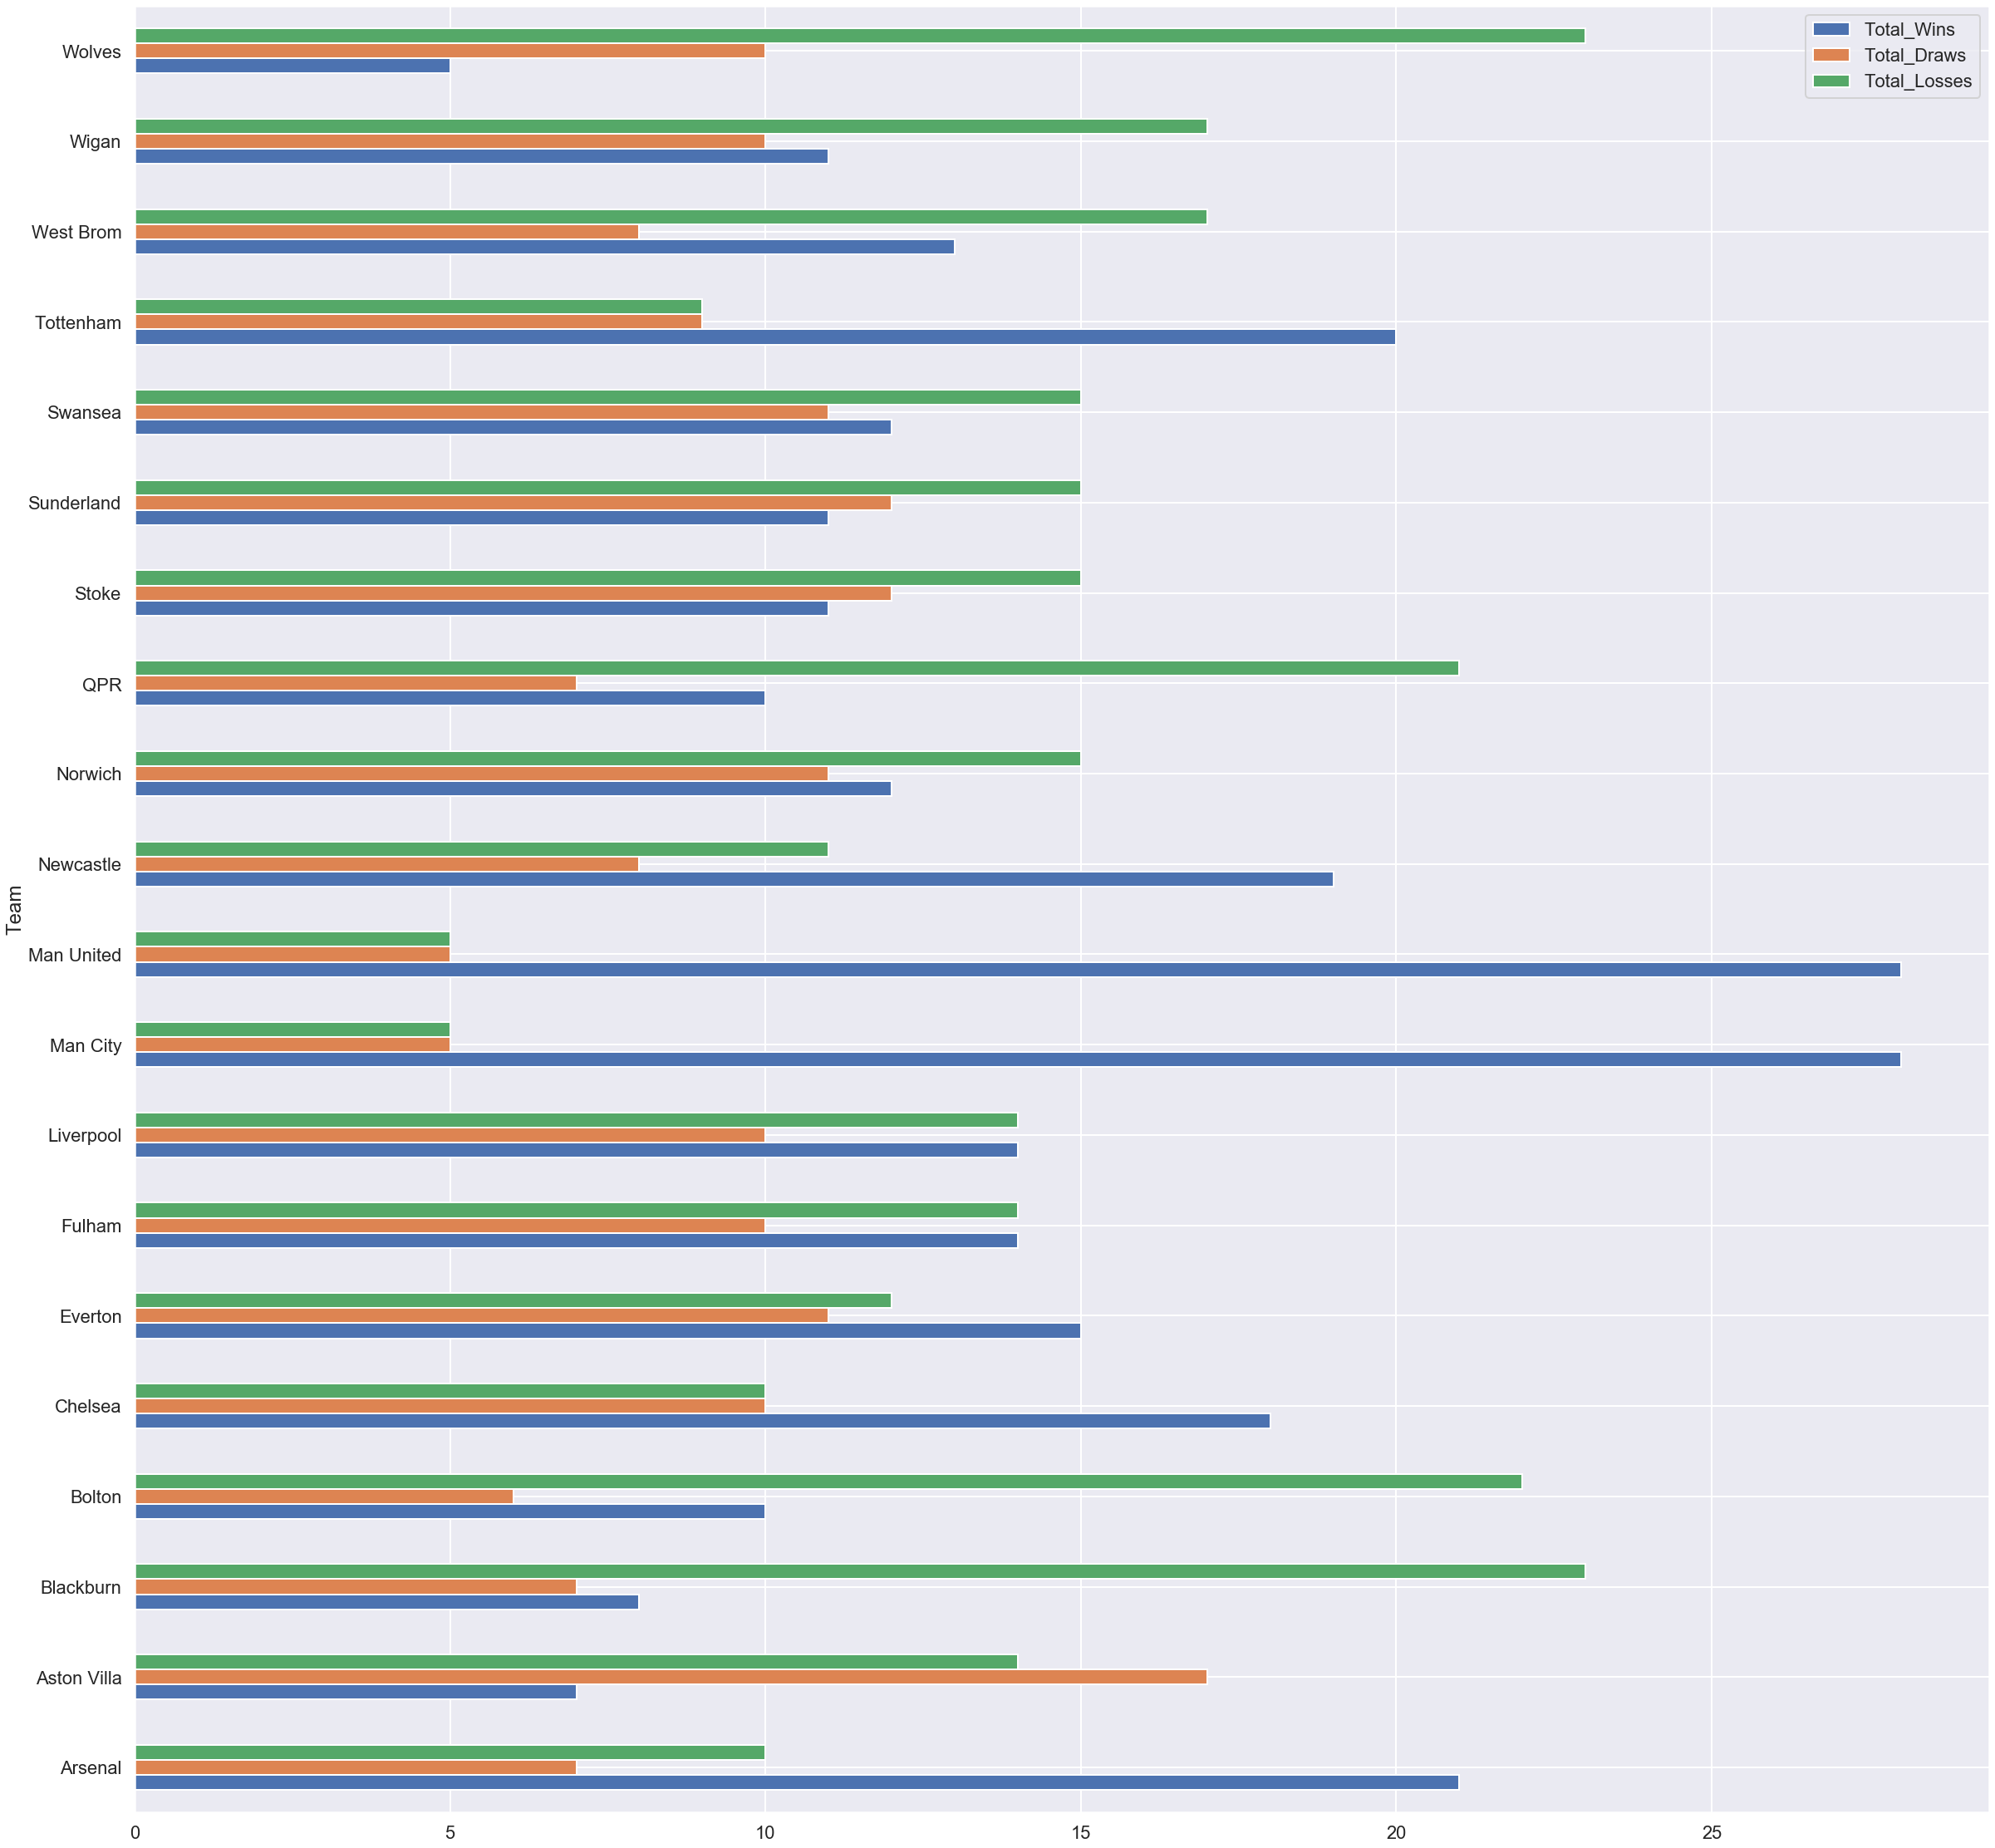

In [21]:
english_pl_df = wins_losses_goals_df.loc[wins_losses_goals_df['League'] == 'EPL']
english_pl_df.plot(kind='barh', x='Team', y=['Total_Wins', 'Total_Draws', 'Total_Losses'], figsize=(40,40))

# Preparing data for weather information 

In [77]:
table_names = cur.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name").fetchall()

In [78]:
table_names = [x[0] for x in table_names]
print(table_names)

['Matches', 'Teams', 'Teams_in_Matches', 'Unique_Teams', 'sqlite_sequence']


In [79]:
dict_table_name_columns = {}
for table in table_names:
    if not dict_table_name_columns.get(table, None):
        dict_table_name_columns[table] = []
    t = list(cur.execute(f"PRAGMA table_info({table})"))
    for item in t:
        dict_table_name_columns[table].append(item[1])
pprint(dict_table_name_columns)

{'Matches': ['Match_ID',
             'Div',
             'Season',
             'Date',
             'HomeTeam',
             'AwayTeam',
             'FTHG',
             'FTAG',
             'FTR'],
 'Teams': ['Season',
           'TeamName',
           'KaderHome',
           'AvgAgeHome',
           'ForeignPlayersHome',
           'OverallMarketValueHome',
           'AvgMarketValueHome',
           'StadiumCapacity'],
 'Teams_in_Matches': ['Match_ID', 'Unique_Team_ID'],
 'Unique_Teams': ['TeamName', 'Unique_Team_ID'],
 'sqlite_sequence': ['name', 'seq']}


In [80]:
df = pd.DataFrame(cur.execute("SELECT * FROM Matches").fetchall())
df.columns = dict_table_name_columns["Matches"]
df = df.loc[(df["Season"] == 2011)]
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
1091,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1092,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
1093,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
1094,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
1095,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [81]:
HomeTeams = list(df["HomeTeam"].unique())
AwayTeams = list(df["AwayTeam"].unique())
Teams = HomeTeams + AwayTeams
Teams = list(set(Teams))

In [82]:
dict_team_wins = {}
dict_team_goals = {}
for team in Teams:
    if not dict_team_wins.get(team, None):
        dict_team_wins[team] = []
    home_wins = list(df.loc[(df["HomeTeam"] == team), "FTR"]).count("H")
    away_wins = list(df.loc[(df["AwayTeam"] == team), "FTR"]).count("A")
    home_goals = sum(list(df.loc[(df["HomeTeam"] == team), "FTHG"]))
    away_goals = sum(list(df.loc[(df["AwayTeam"] == team), "FTAG"]))
    dict_team_wins[team] = home_wins + away_wins
    dict_team_goals[team] = home_goals + away_goals

In [83]:
df["Date"] = pd.DatetimeIndex(df['Date'])

In [84]:
df["Date"][1091]

Timestamp('2012-03-31 00:00:00')

In [85]:
len(df)

992

In [86]:
datetime.timestamp(df["Date"][1092])

1323561600.0

# OOP Class

In [90]:
class WeatherGetter():
    def __init__(self, lat="52.520008", long="13.404954", time=datetime.now().timestamp()):
        self.lat = lat
        self.long = long
        self.time = int(time)
        self.key = key
        self.request_obj = requests.get(f"https://api.darksky.net/forecast/{self.key}/{self.lat},{self.long},{self.time}")
    
    def set_lat(self, lat):
        self.lat = lat
    
    def set_long(self, long):
        self.long = long
        
    def set_time(self, date=datetime.now().timestamp(), date_format=False):
        if date_format:
            date = int(datetime.timestamp(date))
        self.time = date
        
    def get_weather(self, data="summary"):
        if not self.request_obj:
            return "No request made"
        if self.request_obj.json().get("currently"):
            if self.request_obj.json()["currently"].get(data):
                return self.request_obj.json()["currently"][data]
            else:
                return "Weather not available"
        else:
            return f"There was a problem, timestamp: {self.time}"

# Get the Darksky API weather data

In [95]:
# select year 2011
cur.execute('''SELECT * FROM Matches
               WHERE Season=2011;''')
df_2011 = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df_2011.head()

,0,1,2,3,4,5,6,7,8
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [24]:
# check season 2011 dates for the weather api
dates_api = cur.execute('''SELECT DISTINCT Date FROM Matches
                              WHERE Season IS 2011;''')
dates_api_df = pd.DataFrame(cur.fetchall())
dates_api_df.columns = [x[0] for x in cur.description]
dates_api_df.head()

,Date
0,2012-03-31
1,2011-12-11
2,2011-08-13
3,2011-11-27
4,2012-02-18


In [25]:
type(dates_api_df)

pandas.core.frame.DataFrame

In [26]:
# Teams' Table
cur.execute('''
SELECT *
FROM Matches
WHERE Season == 2011
''')
match_df = pd.DataFrame(cur.
                        fetchall())
match_df.columns = [x[0] for x in cur.description]
match_df.head(10)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D
5,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H
6,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,D
7,1099,D1,2011,2012-04-21,Werder Bremen,Bayern Munich,1,2,A
8,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,A
9,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,H


In [27]:
dates_list = []
for date in dates_api_df.Date:
        dates_list.append(date + 'T17:00:00')
dates_list

['2012-03-31T17:00:00',
 '2011-12-11T17:00:00',
 '2011-08-13T17:00:00',
 '2011-11-27T17:00:00',
 '2012-02-18T17:00:00',
 '2012-01-20T17:00:00',
 '2012-02-04T17:00:00',
 '2012-04-21T17:00:00',
 '2011-09-18T17:00:00',
 '2011-10-23T17:00:00',
 '2011-10-01T17:00:00',
 '2012-03-03T17:00:00',
 '2011-08-27T17:00:00',
 '2012-03-17T17:00:00',
 '2011-11-06T17:00:00',
 '2012-05-05T17:00:00',
 '2012-04-11T17:00:00',
 '2011-12-17T17:00:00',
 '2012-02-03T17:00:00',
 '2011-10-29T17:00:00',
 '2012-01-22T17:00:00',
 '2011-12-03T17:00:00',
 '2012-04-14T17:00:00',
 '2012-03-25T17:00:00',
 '2012-03-10T17:00:00',
 '2012-04-07T17:00:00',
 '2011-11-19T17:00:00',
 '2011-10-14T17:00:00',
 '2011-09-24T17:00:00',
 '2012-04-28T17:00:00',
 '2011-12-18T17:00:00',
 '2012-03-02T17:00:00',
 '2012-03-16T17:00:00',
 '2012-02-17T17:00:00',
 '2011-08-06T17:00:00',
 '2011-11-04T17:00:00',
 '2011-09-16T17:00:00',
 '2011-07-15T17:00:00',
 '2012-05-06T17:00:00',
 '2012-02-11T17:00:00',
 '2011-10-02T17:00:00',
 '2012-03-30T17:

In [38]:
weather_dates={}

for date in dates_list:
    weather = requests.get(f'https://api.darksky.net/forecast/52e4fc960da0c65d416ae893288db7df/52.5200, 13.4050, {date}').json()
    weather_like = weather['currently']
weather_dates[date] = weather_like
    
weather_dates

{'2012-05-13T17:00:00': {'time': 1336921200,
  'summary': 'Mostly Cloudy',
  'icon': 'partly-cloudy-day',
  'precipIntensity': 0,
  'precipProbability': 0,
  'temperature': 53.64,
  'apparentTemperature': 53.64,
  'dewPoint': 35.82,
  'humidity': 0.51,
  'windSpeed': 6,
  'windGust': 6,
  'windBearing': 303,
  'cloudCover': 0.75,
  'uvIndex': 2,
  'visibility': 6.216}}

In [46]:
cur.execute('''
SELECT *
FROM Matches
WHERE Season == 2011
''')
df_match = pd.DataFrame(cur.
                        fetchall())
df_match.columns = [x[0] for x in cur.description]
df_match.head(10)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D
5,1097,D1,2011,2012-01-20,M'gladbach,Bayern Munich,3,1,H
6,1098,D1,2011,2012-02-04,Hamburg,Bayern Munich,1,1,D
7,1099,D1,2011,2012-04-21,Werder Bremen,Bayern Munich,1,2,A
8,1100,D1,2011,2011-09-18,Schalke 04,Bayern Munich,0,2,A
9,1101,D1,2011,2011-10-23,Hannover,Bayern Munich,2,1,H


In [47]:
date_list = list(df_match['Date'])
str_date_list = []
for date in date_list:
    new_date = date + 'T19:00:00'
    str_date_list.append(new_date)
str_date_list

['2012-03-31T19:00:00',
 '2011-12-11T19:00:00',
 '2011-08-13T19:00:00',
 '2011-11-27T19:00:00',
 '2012-02-18T19:00:00',
 '2012-01-20T19:00:00',
 '2012-02-04T19:00:00',
 '2012-04-21T19:00:00',
 '2011-09-18T19:00:00',
 '2011-10-23T19:00:00',
 '2011-10-01T19:00:00',
 '2012-03-03T19:00:00',
 '2011-08-27T19:00:00',
 '2012-03-17T19:00:00',
 '2011-11-06T19:00:00',
 '2012-05-05T19:00:00',
 '2012-04-11T19:00:00',
 '2011-08-27T19:00:00',
 '2011-12-17T19:00:00',
 '2012-02-18T19:00:00',
 '2012-02-03T19:00:00',
 '2011-08-13T19:00:00',
 '2011-10-29T19:00:00',
 '2012-01-22T19:00:00',
 '2011-12-03T19:00:00',
 '2012-04-14T19:00:00',
 '2011-09-18T19:00:00',
 '2012-03-25T19:00:00',
 '2012-03-10T19:00:00',
 '2012-04-07T19:00:00',
 '2011-11-19T19:00:00',
 '2011-10-14T19:00:00',
 '2011-09-24T19:00:00',
 '2012-04-28T19:00:00',
 '2011-12-18T19:00:00',
 '2012-03-02T19:00:00',
 '2012-03-16T19:00:00',
 '2012-02-17T19:00:00',
 '2011-08-06T19:00:00',
 '2011-11-04T19:00:00',
 '2011-09-16T19:00:00',
 '2011-07-15T19:

In [96]:
df_match.head(10)

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31T19:00:00,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11T19:00:00,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13T19:00:00,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27T19:00:00,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18T19:00:00,Freiburg,Bayern Munich,0,0,D
5,1097,D1,2011,2012-01-20T19:00:00,M'gladbach,Bayern Munich,3,1,H
6,1098,D1,2011,2012-02-04T19:00:00,Hamburg,Bayern Munich,1,1,D
7,1099,D1,2011,2012-04-21T19:00:00,Werder Bremen,Bayern Munich,1,2,A
8,1100,D1,2011,2011-09-18T19:00:00,Schalke 04,Bayern Munich,0,2,A
9,1101,D1,2011,2011-10-23T19:00:00,Hannover,Bayern Munich,2,1,H


In [97]:
weather_dates['2011-08-08T17:00:00']['icon']

KeyError: '2011-08-08T17:00:00'

# Creating Weather Dataframe

In [53]:
pd.set_option('display.max_columns', None)
raining_df = pd.DataFrame(list(weather_dates.items()), columns=['date', 'weather']) 
raining_df.head()

,date,weather
0,2012-05-13T17:00:00,"{'time': 1336921200, 'summary': 'Mostly Cloudy..."


# Raining Dates 

In [54]:
raining_dates = []
for timestamp in weather_dates:
    if 'icon' in weather_dates[timestamp] and weather_dates[timestamp]['icon'] == 'rain':
        raining_dates.append(timestamp)
raining_dates

[]

In [55]:
len(raining_dates)

0

# Splitting raining date into raining hours

In [56]:
rain = []
for i in raining_dates:
    rain.append(i.split('T')[0])
    
rain

[]

In [57]:
just_rain = pd.DataFrame()

for date in rain:
    d = df[(df['Date'] == date)]
    just_rain = pd.concat([just_rain,d])
just_rain.head()

""


# Total Wins for each team during raining matches (%)

Hansa Rostock 0%

Bochum 50%

FC Koln 0%

Duisburg 0%

Ingolstadt 0%

Mainz 0%

Cottbus 100%

Erzgebirge Aue 0%

Frankfurt FSV 0%

# Mongo DB

# OOP Class 

In [98]:
class MongoHandler():
    def __init__(self, dbname):
        self.myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
        self.mydb = myclient[dbname]
        self.dblist = self.myclient.list_database_names()
        
    def create_table(self, table_name):
        self.mycollection = self.mydb[table_name]
        return self.mycollection
    
    def insert_rows(self, row_or_rows):
        if type(row_or_rows) or type(row_or_rows):
            return "The input should be a list of dictionnaries or a dictionnary"
        if type(row_or_rows) == list and type(row_or_rows[0]) == dict:
            result = self.mycollection.insert_many(row_or_rows)
        if type(row_or_rows) == dict:
            result = self.mycollection.insert_one(row_or_rows)
        return result
    
    def query(self, query={}):
        if type(query) != dict:
            return "The query should in a dictionnary format"
        return self.mycollection.find(query)
    
    def update(self, record_to_update, update):
        if type(record_to_update) != dict or type(update) != dict:
            return "At least one of the inputs is not a dictionnary"
        update = {'$set': update}
        return self.mycollection.update_one(record_to_update, update)

In [99]:
# my mongo
mymongo = pymongo.MongoClient("mongodb://127.0.0.1:27017/") 
mymongo

MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True)

In [101]:
# grab a database from your server
mydb = mymongo['wins_losses_goals_df']

In [102]:
# initialize an empty collection
mycollection = mydb['teams']

In [103]:
mydict = list(wins_losses_goals_df.to_dict (orient = 'records'))

In [104]:
df_Q123_to_dict = wins_losses_goals_df.to_dict(orient = 'records')

In [105]:
mycollection.insert_many(mydict)

In [106]:
mydb = mymongo['Football_Delphi_Project']

In [107]:
mymongo.list_database_names()

['Football_Delphi_Project', 'admin', 'config', 'local', 'wins_losses_goals_df']

In [108]:
mycollection = mydb['Football_Delphi_Project']

In [109]:
mymongo.list_database_names()

['Football_Delphi_Project', 'admin', 'config', 'local', 'wins_losses_goals_df']

In [110]:
mydb.list_collection_names()

['Plots', 'Football_Delphi_Project']

In [111]:
df_Q123_to_dict = wins_losses_goals_df.to_dict(orient = 'records')

In [112]:
df_Q123_to_dict

[{'Team': 'Aachen',
  'Total_Goals': 30,
  'Total_Wins': 6,
  'Total_Draws': 13,
  'Total_Losses': 15,
  'Num_Games': 34,
  'League': 'BUNDES'},
 {'Team': 'Arsenal',
  'Total_Goals': 74,
  'Total_Wins': 21,
  'Total_Draws': 7,
  'Total_Losses': 10,
  'Num_Games': 38,
  'League': 'EPL'},
 {'Team': 'Aston Villa',
  'Total_Goals': 37,
  'Total_Wins': 7,
  'Total_Draws': 17,
  'Total_Losses': 14,
  'Num_Games': 38,
  'League': 'EPL'},
 {'Team': 'Augsburg',
  'Total_Goals': 36,
  'Total_Wins': 8,
  'Total_Draws': 14,
  'Total_Losses': 12,
  'Num_Games': 34,
  'League': 'BUNDES'},
 {'Team': 'Bayern Munich',
  'Total_Goals': 77,
  'Total_Wins': 23,
  'Total_Draws': 4,
  'Total_Losses': 7,
  'Num_Games': 34,
  'League': 'BUNDES'},
 {'Team': 'Blackburn',
  'Total_Goals': 48,
  'Total_Wins': 8,
  'Total_Draws': 7,
  'Total_Losses': 23,
  'Num_Games': 38,
  'League': 'EPL'},
 {'Team': 'Bochum',
  'Total_Goals': 41,
  'Total_Wins': 10,
  'Total_Draws': 7,
  'Total_Losses': 17,
  'Num_Games': 34,
 

In [113]:
# adding my dict to my collection
mycollection.insert_many(df_Q123_to_dict)

In [114]:
query = mycollection.find({})
for document in query:
    print(document)

{'_id': ObjectId('5e341fc07d09e085c190f022'), 'Team': 'Aachen', 'Total_Goals': 30, 'Total_Wins': 6, 'Total_Draws': 13, 'Total_Losses': 15, 'Num_Games': 34, 'League': 'BUNDES'}
{'_id': ObjectId('5e341fc07d09e085c190f023'), 'Team': 'Arsenal', 'Total_Goals': 74, 'Total_Wins': 21, 'Total_Draws': 7, 'Total_Losses': 10, 'Num_Games': 38, 'League': 'EPL'}
{'_id': ObjectId('5e341fc07d09e085c190f024'), 'Team': 'Aston Villa', 'Total_Goals': 37, 'Total_Wins': 7, 'Total_Draws': 17, 'Total_Losses': 14, 'Num_Games': 38, 'League': 'EPL'}
{'_id': ObjectId('5e341fc07d09e085c190f025'), 'Team': 'Augsburg', 'Total_Goals': 36, 'Total_Wins': 8, 'Total_Draws': 14, 'Total_Losses': 12, 'Num_Games': 34, 'League': 'BUNDES'}
{'_id': ObjectId('5e341fc07d09e085c190f026'), 'Team': 'Bayern Munich', 'Total_Goals': 77, 'Total_Wins': 23, 'Total_Draws': 4, 'Total_Losses': 7, 'Num_Games': 34, 'League': 'BUNDES'}
{'_id': ObjectId('5e341fc07d09e085c190f027'), 'Team': 'Blackburn', 'Total_Goals': 48, 'Total_Wins': 8, 'Total_Dr

In [115]:
resp1 = requests.get ('http://localhost:8888/view/image1_delphi_project.jpg')
resp2 = requests.get ('http://localhost:8888/view/image2_delphi_project.jpg')

In [116]:
img1 = resp1.content
img2 = resp2.content
newcollection = mydb['Plots']

In [117]:
anewdict1 = {'a': 4, 'image': img1}
anewdict2 = {'a': 4, 'image': img2}
newcollection.insert_one(anewdict1)
newcollection.insert_one(anewdict2)

In [118]:
_.inserted_id

ObjectId('5e34338b4f4a4170664b1aa6')

In [119]:
from IPython.display import Image

results = newcollection.find_one({'_id': _})
newimg = results.get('image')

len(newimg)
# Image(newimg)
with open('./mongo.jpg', 'wb') as f:
    f.write(newimg)